In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

В этом блокноте мы рассмотрим модель Хольта-Винтерса.

Загрузим данные о потреблении электроэнергии на юго-востоке Бразилии (2009-2017).

In [2]:
electricity = pd.read_excel('/content/sample_data/Потребление электроэнергии на юго-востоке Бразилии.xls')
electricity

,2009-01-01,2009-02-01,2009-03-01,2009-04-01,2009-05-01,2009-06-01,2009-07-01,2009-08-01,2009-09-01,2009-10-01,...,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01
0,656518.039202,723192.969315,818306.259787,898910.328976,1.027720e+06,1.012580e+06,1.061824e+06,1.084292e+06,1.197381e+06,1.278430e+06,...,967520.994628,1.020786e+06,1.070603e+06,1.197483e+06,1.260629e+06,1.300039e+06,1.381843e+06,1.405459e+06,1.566660e+06,1.088329e+06


In [3]:
electricity = electricity.rename({0: 'Electricity'}, axis='index').transpose()
electricity


,Electricity
2009-01-01,6.565180e+05
2009-02-01,7.231930e+05
2009-03-01,8.183063e+05
2009-04-01,8.989103e+05
2009-05-01,1.027720e+06
...,...
2016-08-01,1.300039e+06
2016-09-01,1.381843e+06
2016-10-01,1.405459e+06
2016-11-01,1.566660e+06


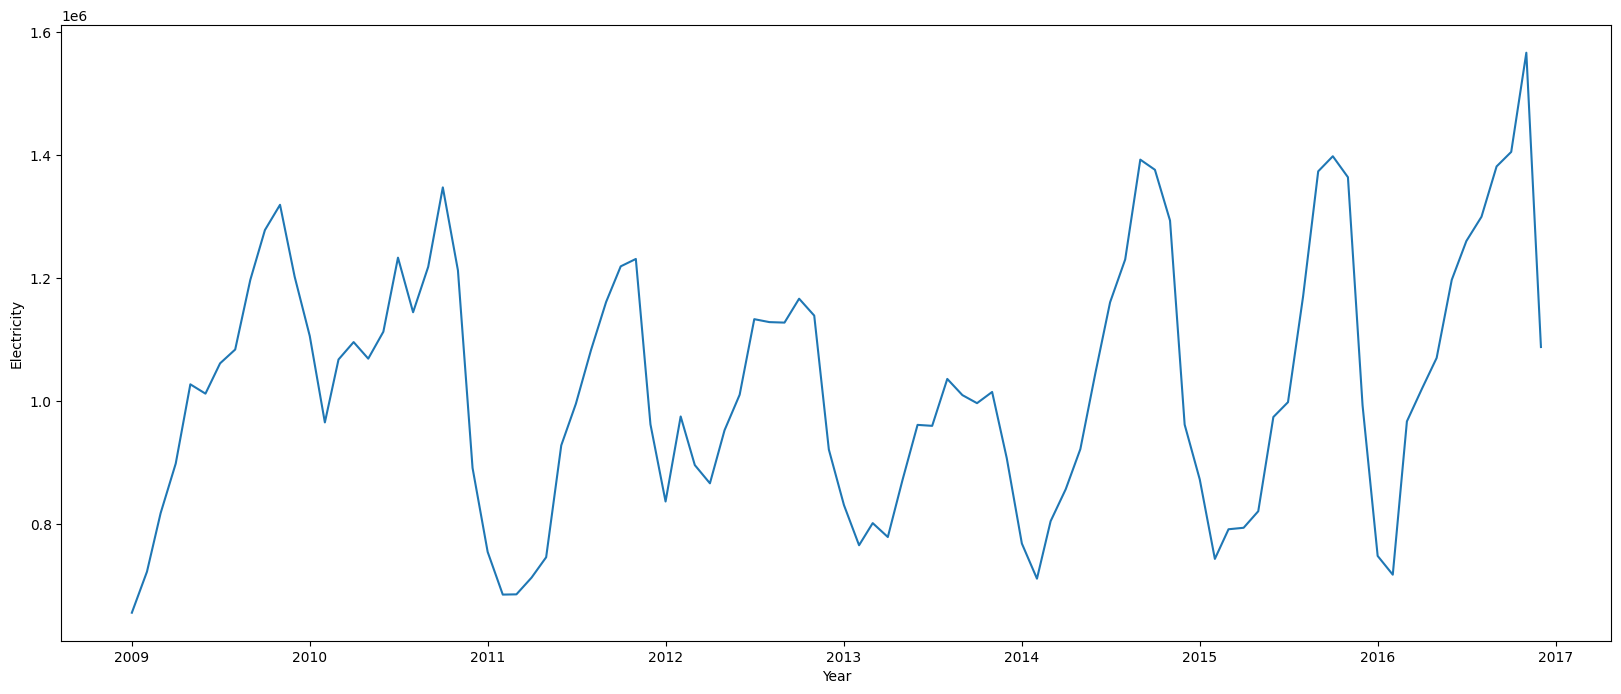

In [4]:
plt.figure(figsize=(20, 8))
plt.plot(electricity.index, electricity['Electricity'])
plt.xlabel('Year')
plt.ylabel('Electricity')
plt.show()

In [5]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2009-01-01 to 2016-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Electricity  96 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


сезонность p

период прогноза h

#Аддитивная модель

Y^[t+h] = a[t] + h * b[t] + s[t - p + 1 + (h - 1) mod p],

a[t] = α (Y[t] - s[t-p]) + (1-α) (a[t-1] + b[t-1]) - сглаживание

b[t] = β (a[t] - a[t-1]) + (1-β) b[t-1] - тренд

s[t] = γ (Y[t] - a[t]) + (1-γ) s[t-p] - сезонность

α, β, γ параметры (0,1).

#Мультипликативная модель

Y^[t+h] = (a[t] + h * b[t]) * s[t - p + 1 + (h - 1) mod p],

a[t] = α (Y[t] / s[t-p]) + (1-α) (a[t-1] + b[t-1]) - сглаживание

b[t] = β (a[t] - a[t-1]) + (1-β) b[t-1] - тренд

s[t] = γ (Y[t] / a[t]) + (1-γ) s[t-p] - сезонность

α, β, γ параметры (0,1).


In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

Выполним декомпозицию (выделим тренд, сезонность и шум):

In [7]:
decompose_result = seasonal_decompose(electricity['Electricity'], model='multiplicative')

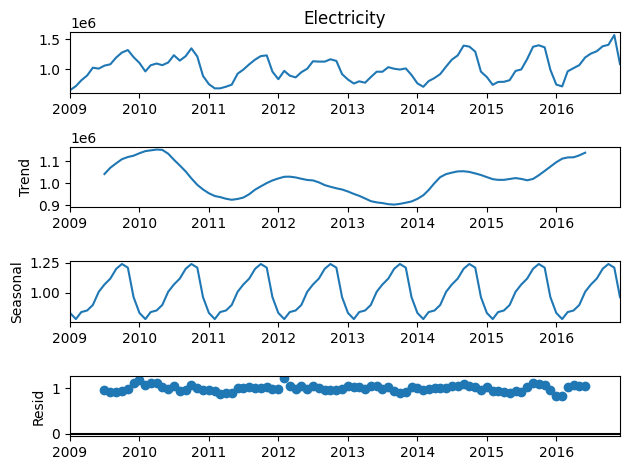

In [8]:
decompose_result.plot()
plt.show()

In [9]:
fit1 = ExponentialSmoothing(electricity['Electricity'],trend='add',seasonal='add',seasonal_periods=12).fit()
fit2 = ExponentialSmoothing(electricity['Electricity'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [10]:
results = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

In [11]:
params = [
    "smoothing_level",
    "smoothing_trend",
    "smoothing_seasonal"
]
results["Additive"] = [fit1.params[p] for p in params]
results["Multiplicative"] = [fit2.params[p] for p in params]
results

,Additive,Multiplicative
$\alpha$,0.888929,0.888929
$\beta$,0.000100,0.000100
$\gamma$,0.012341,0.037024


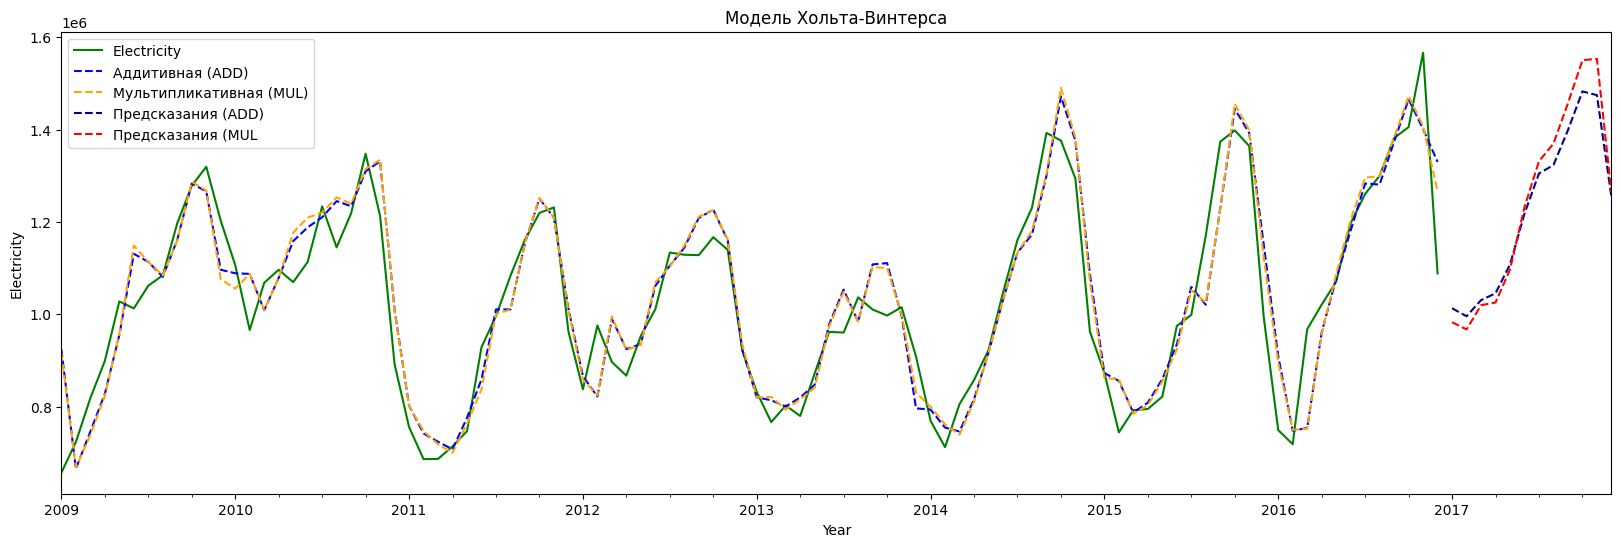

In [12]:
ax = electricity.plot(
    figsize=(20, 6),
    color="green",
    title="Mодель Хольта-Винтерса")
ax.set_ylabel("Electricity")
ax.set_xlabel("Year")
fit1.fittedvalues.rename("Аддитивная (ADD)").plot(ax=ax, style="--", color="blue",legend=True)
fit2.fittedvalues.rename("Мультипликативная (MUL)").plot(ax=ax, style="--", color="orange",legend=True)
fit1.forecast(12).rename("Предсказания (ADD)").plot(
    ax=ax, style="--",  color="darkblue", legend=True)
fit2.forecast(12).rename("Предсказания (MUL").plot(
    ax=ax, style="--",  color="red", legend=True)
plt.show()

In [13]:
electricity['ADD'] = fit1.fittedvalues
electricity['MUL'] = fit2.fittedvalues
electricity

,Electricity,ADD,MUL
2009-01-01,6.565180e+05,9.236191e+05,9.153386e+05
2009-02-01,7.231930e+05,6.651893e+05,6.679046e+05
2009-03-01,8.183063e+05,7.457904e+05,7.379321e+05
2009-04-01,8.989103e+05,8.276206e+05,8.226519e+05
2009-05-01,1.027720e+06,9.549906e+05,9.583054e+05
...,...,...,...
2016-08-01,1.300039e+06,1.280978e+06,1.299652e+06
2016-09-01,1.381843e+06,1.373679e+06,1.383045e+06
2016-10-01,1.405459e+06,1.465767e+06,1.472817e+06
2016-11-01,1.566660e+06,1.401257e+06,1.407655e+06


In [14]:
print('ADD MAPE(%) = ', round(np.average(abs((electricity['ADD'] - electricity['Electricity'])/electricity['Electricity']*100)),1))
print('MUL MAPE(%) = ', round(np.average(abs((electricity['MUL'] - electricity['Electricity'])/electricity['Electricity']*100)),1))

ADD MAPE(%) =  6.2
MUL MAPE(%) =  6.2
